# Multivariable Regression and Bias

Extension of single variable regression to Multiple Regression, add sklearn component to it and explain the coeficients (Varun)

Video: Prediction, and list reason why the model is fit for prediction(some aren't, example?), use a different dataset(Varun, Grace)

Video: Reading and evaluating residual plots, need the residuals to be centered around 0, normal evaluation(?). （Grace）

Video - feature selection and validation using RMSE + train/test split （Andrei）

Accuracy and the related stats: TP, FP, TN, FN, sensitivity, specificity (Ervin)


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import warnings
warnings.simplefilter("ignore")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import patches
%matplotlib inline
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

nlsy = pd.read_csv('nlsy_cleaned_small.csv')
nlsy['college'] = nlsy['college'].astype(float)
nlsy['AFQT'] = nlsy["AFQT"].astype(float)

Our procedure earlier showed that we expect to see roughly a 70% increase in earnings in people who went to college vs. people who did not go to college. Does this imply that your decision to go to college was worthwhile, and now you can expect to have roughly 70% higher earnings compared to the version of you who did not go to college?

Let's go back to our discussion of experiments from earlier. In an ideal experiment, we would want a good sample of people who are about to graduate high school, and then randomly assign them to either a treatment group that gets sent to college, and a control group that does not. If you are in the treatment group you *must* go to college, and if you are in the control group you *cannot* go to college. Since the decision to go to college in this case is completely random, we can safely assume that the treatment and control groups are on average identical in attributes, apart from college attendance. We can therefore compare their log earnings in the future to see the effect of going to college.

Clearly this experiment is impossible to perform. We cannot randomly assign people to go to college. What's different between this ideal experiment and our regression from earlier? What's the issue with comparing the differences in log earnings for people in our sample who happened to go to college and those who did not?

In our sample, the treatment (went to college) and control (did not go to college) groups are not identical in every way except for college! People aren't randomly assigned college, they *choose* to go to college. The factors that cause someone to go to college are complex and lead to differences between people who chose to go to college and those who did not. When we perform regression on the variable `college`, since the groups in the sample are different, not only are we capturing the effect of going to college, but we are also capturing the effects of everything else that is different about the two groups that also affects earnings.

Imagine another variable that captures the wealth of your family. College can be very expensive, so it might be the case that the wealthier your family is, the more likely you are to go to college. Also, it's easy to imagine that the wealthier your family is, the wealthier you are likely to be in the future. This implies that the group of people in the sample who went to college will tend to be wealthier than the group that did not. Also, the group of people who went to college is expected to earn more not necessarily because they went to college, but simply because they are wealthier.

Therefore, when we do regression to measure the differences in earnings between people who went to college and those who did not, we also capture differences in earnings between people who grew up wealthier and those who did not. Because of this, we *over-estimate* the effect of going to college. $\hat{\beta}$ captures the average observed benefit of going to college *and* being wealthier, but we're only interested in college. This is called *omitted variable bias*. Family wealth is an omitted variable in this regression and it's causing our results to be biased.

Let's think of another example of omitted variable bias. In the NLSY dataset, there is a variable called `AFQT`. AFQT is a score on a particular standardized test that all people in the sample took. Let's use AFQT as a proxy measurement for the abstract idea of academic capability. While a standardized test is by no means the sole indication of someone's ability or intelligence, let's ignore that very complicated issue for now and assume that AFQT does an O.K. job at capturing this ability variable that is otherwise very difficult to measure.

Is there omitted variable bias from AFQT? Almost certainly. It seems fair to believe that people who choose to go to college are on average more academically-capable, and it also seems fair to say that on average we expect more capable people to earn more. Therefore, $\hat{\beta}$ above might be capturing the effects of being more capable, along with the effects of going to college.

How can we fix this issue? Multivariable regression.

## Multivariable Regression

So far we have only been regressing outcome variable $y$ onto one explanatory variable $x$. To find the regression line, we choose $\hat{\alpha}$ and $\hat{\beta}$ that minimize the mean squared error. But what if we believe that $y$ is actually determined by two variables, $x_1$ and $x_2$? Specifically, what if the "true" model is

$$
y = \alpha + \beta_1 x_{1} + \beta_2 x_{2} + \epsilon
$$

and we would like to estimate

$$
\hat{y} = \hat{\alpha} + \hat{\beta}_1 x_{1} + \hat{\beta}_2 x_{2}
$$

Now our challenge is choosing $\hat{\alpha}$, $\hat{\beta}_1$, *and* $\hat{\beta}_2$ that minimize the mean squared error. To this end, we will use the `minimize` function to minimize a function `to_minimize` that takes in model parameters and returns the model's RMSE.

In [23]:
def rmse(target, pred):
    return np.sqrt(mean_squared_error(target, pred)) 

def to_minimize(params):
    intercept, beta_1, beta_2 = params
    predictions = intercept + beta_1 * nlsy['college'] + beta_2 * nlsy['AFQT']
    actual = nlsy['log_earn_1999']
    return rmse(predictions, actual)

minimize(to_minimize, [0, 0, 0]).x

array([9.95630229e+00, 4.30124617e-01, 8.37218402e-03])

We see that `minimize` return an $\hat{\alpha}$ of 9.956, a $\hat{\beta}_1$ of 0.430, and a $\hat{\beta}_2$ of 0.008. Let's perform the regression using `scikit-learn` and see what we get. As before, we use the same `LinearRegression` model for both single and multivariable regression. Recall that previously, our design matrix $X$ only consisted of one column, but now it should contain two, for each explanatory variable.

In [24]:
y = nlsy['log_earn_1999']
X = nlsy[['college', 'AFQT']]

model1 = lm.LinearRegression().fit(X, y)
print([model1.intercept_, model1.coef_[0], model1.coef_[1]])

[9.956300947350114, 0.4301233843374295, 0.008372219011608924]


The intercept and coefficients match up to the manually calculated values above. 

Here $\hat{\beta}_1$ is 0.43, compared to 0.72 from the earlier biased (single variable) regression. That's huge! This implies that when we control for a person's ability (i.e. we get rid of that source of bias), we only see that on average going to college is associated with a 43% increase in earnings instead of 72%.

These observations validate our claim that AFQT was probably an omitted variable causing $\hat{\beta}_1$ to be biased. When interpreting $\hat{\beta}$ coefficients, you should always be mindful of potential sources of bias that could make your coefficients misleading and not useful from a statistical context.

**Note:** A linear regression model makes predictions for $y$ which we've been calling $\hat{y}$. If you imagine that you are the model and are tasked with predicting people's earnings, you will almost certainly want more than just their years of schooling to make an accurate prediction. The more relevant variables you are given, the better predictions you are likely to make compared to just using one variable. The variable needs to be relevant though; the day of the week a person was born on is probably not useful in predicting earnings. This is just another way of thinking about the usefulness of multivariable regression.

### Visualizing Multivariable Regression

The 3D plots below show us our variables of interest and the regression plane from two different angles.

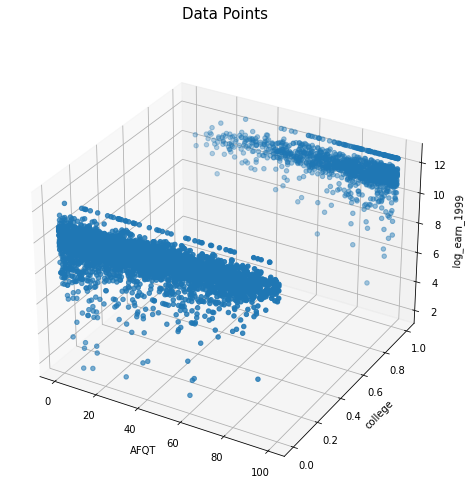

In [25]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(nlsy["AFQT"], 
           nlsy["college"], 
           nlsy['log_earn_1999'])
plt.xlabel("AFQT")
plt.ylabel("college")
ax.set_zlabel("log_earn_1999")
plt.title("Data Points", pad=30, size=15);

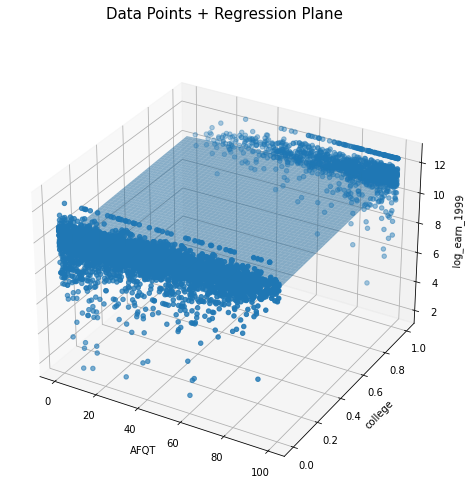

In [26]:
X,Y = np.meshgrid(np.arange(0,100,1), np.arange(0,1,0.01))
Z = 0.0084 * X + 0.4301 * Y + 9.9563
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(nlsy["AFQT"], 
           nlsy["college"], 
           nlsy['log_earn_1999'])
ax.plot_surface(X, Y, Z, alpha=0.5)
plt.xlabel("AFQT")
plt.ylabel("college")
ax.set_zlabel("log_earn_1999")
plt.title("Data Points + Regression Plane", pad=30, size=15);

Here is the same visualization with axes switched.

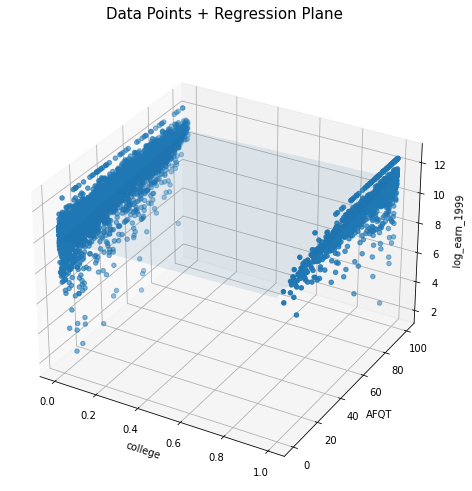

In [27]:
X,Y = np.meshgrid(np.arange(0,1,0.01), np.arange(0,100,1))
Z = 0.4301 * X + 0.0084 * Y + 9.9563
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(nlsy["college"], 
           nlsy["AFQT"], 
           nlsy['log_earn_1999'])
ax.plot_surface(X, Y, Z, alpha=0.1)
plt.ylabel("AFQT")
plt.xlabel("college")
ax.set_zlabel("log_earn_1999")
plt.title("Data Points + Regression Plane", pad=30, size=15);

The regression plane, instead of the regression line, represents the values for log earnings that the regression model would predict for any given college and AFQT input. It's a plane now because there are two possible inputs, as opposed to one.

## Colinearity and Dummy Variables

When we do regression onto the variable `college`, why don't we also include a variable that measures not going to college? In other words, why don't we regress on college and the opposite of college so that way we can get an estimate of the average earnings of college-goers and non-college-goers. Why do we do this roundabout way of using the intercept term and a difference in means?

Imagine we have a dataset with a variable for college, a variable for not going to college, and the intercept term. The issue with this is that there is now redundant information.

Let's look at just one element of the sample. Let's say this person went to college, so this person's features are the following:
* College = 1
* Not College = 0
* Intercept term = 1

Clearly there is a redundancy here; you can guess one of the variables from the others. More specifically, by redundancy we mean that *one variable can be written as a linear combination of the other variables*. In fact, there are three different combinations:
* Intercept = College + Not College
* Not College = Intercept - College
* College = Intercept - Not College

These equalities aren't just true for this one person; they actually hold true for any possible person in the sample. This is because of the way we defined "college" and "not college". You can't simultaneously be in both, and so adding them together you get 1, which is just the intercept term.

In general, we have redundancy whenever we have *mutually exclusive* and *exhaustive* dummy variables in combination with an intercept term.
* Mutually exclusive: You cannot be in more than one dummy variable.
* Exhaustive: You must be in at least one dummy variable.

You can see that "college" and "not college" satisfy these conditions. So why is this redundancy an issue? It becomes ambiguous what the values for $\hat{\alpha}$, $\hat{\beta}_1$, and $\hat{\beta}_2$ should be in the model where we include all three terms:

$$
\text{log earnings} = \hat{\alpha} + \hat{\beta}_1 \text{college} + \hat{\beta}_2 \text{not college}
$$

Consider a case where we expect people who went to college to have log earnings of 10 and those who did not go to college to have log earnings of 8. What values for $\hat{\beta}$ and $\hat{\alpha}$ make sense?

* $\hat{\beta}_1 = 10$
* $\hat{\beta}_2 = 8$
* $\hat{\alpha} = 0$

These are valid values for $\hat{\beta}$ and $\hat{\alpha}$ that satisfy the condition above. To see why, consider a person with college:

$$
\text{log earnings} = \hat{\alpha} + \hat{\beta}_1 \cdot 1 + \hat{\beta}_2 \cdot 0 
\text{log earnings} = \hat{\alpha} + \hat{\beta}_1 
\text{log earnings} = 0 + 10 = 10
$$

and a person without college:

$$
\text{log earnings} = \hat{\alpha} + \hat{\beta}_1 \cdot 0 + \hat{\beta}_2 \cdot 1 
\text{log earnings} = \hat{\alpha} + \hat{\beta}_2 
\text{log earnings} = 0 + 8 = 8
$$

* $\hat{\beta}_1 = 2$
* $\hat{\beta}_2 = 0$
* $\hat{\alpha} = 8$

also make sense. To see why, consider a person with college:

$$
\text{log earnings} = \hat{\alpha} + \hat{\beta}_1 \cdot 1 + \hat{\beta}_2 \cdot 0
\text{log earnings} = \hat{\alpha} + \hat{\beta}_1 
\text{log earnings} = 8 + 2 = 10
$$

and a person without college:

$$
\text{log earnings} = \hat{\alpha} + \hat{\beta}_1 \cdot 0 + \hat{\beta}_2 \cdot 1
\text{log earnings} = \hat{\alpha} + \hat{\beta}_2 
\text{log earnings} = 8 + 0 = 8
$$

It turns out, there are actually infinitely many solutions for $\hat{\beta}$ that satisfy the condition where people who went to college have mean log earnings of 10 and people who did not go to college have mean log earnings of 8. This holds true for all situations where you regress on a constant and a set of mutually exclusive and exhaustive dummies. There is no unique solution for $\hat{\beta}$, which is a problem for econometricians who want unique and interpretable coefficients.

In fact, there is mathematical justification for this as well. At some point in the math involved in performing regression, having redundant variables causes a division by 0. This is particularly upsetting for your computer, and it will complain.

So how do we avoid this problem? We deliberately exclude one of the variables. It can technically either be one of the dummy variables or the intercept term, but we usually really want to have an intercept term present in our regression for other reasons. So we usually get rid of one of the dummy variables. Notice that we implicitly did this earlier. We did not include "not college" in our first regression.

## Building a Multivariate Regression Model 

### Car Data EDA and Visualization

Now that we have understand the math behind multiple regression and have seen an example visualized, it's time to build our own model from the very start! 
We'll be using a dataset containing various characteristics about used cars on the market, and will be predicting their selling price based on these characteristics. Before we begin, take a look at the description of the dataset and it's variables here: https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho.

In [28]:
cars = pd.read_csv('car_data.csv')
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


### Dummy Variables and One-Hot Encoding

We would like to predict the price of the car based on its other attributes. 
For our purposes, it may be beneficial to not consider the name variable when predicting the price of the car, 
since we want to evaluate all car models equally. 
Note that this assumption may not be correct in the actual car market, which can also lead to a intersting reserch question to ask: Do specific car models sell for a higher price than average on the second had market? 

But I digress, for our purposes, we want to consider the whole market, and not model our regression to specifc car models. So in the following cell, we will first remove the `name` column from the data frame.

In [29]:
cars = cars.drop(columns=['name'])
cars_with_dummies = pd.get_dummies(cars, drop_first=True)
cars_with_dummies

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2007,60000,70000,0,0,0,1,1,0,1,0,0,0,0
1,2007,135000,50000,0,0,0,1,1,0,1,0,0,0,0
2,2012,600000,100000,1,0,0,0,1,0,1,0,0,0,0
3,2017,250000,46000,0,0,0,1,1,0,1,0,0,0,0
4,2014,450000,141000,1,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,2014,409999,80000,1,0,0,0,1,0,1,0,1,0,0
4336,2014,409999,80000,1,0,0,0,1,0,1,0,1,0,0
4337,2009,110000,83000,0,0,0,1,1,0,1,0,1,0,0
4338,2016,865000,90000,1,0,0,0,1,0,1,0,0,0,0


As you saw above in the explanation of multicollinearity, we have to numerically encode categorical variables in order to use them for the purposes of regression. 
This process is called one-hot encoding, where each possible value in a category gets its own column with a binary 1/0 value corresponding to what category it belongs in.
As stated above, one column from each category must be dropped to prevent redundancy. 

Luckily, pandas has a function `get_dummies` which does this work for you!
It even has an optional argument "drop_first" that will automatically drop one of the columns per category. 
Once again, we do this because including every variable would make linear combinations of columns possible with the intercept term.
Removing one of the encoded columns prevents this, and allows our design matrix to be full rank.

## Building the model and prediction
After getting the dummy variables, let's try fitting a multivariate regression model to our cars data! 
We are trying to predict the price of the care using all the other information we have in the table. 

In [30]:
from sklearn import linear_model as lm

# assign model to a variable 
model1 = lm.LinearRegression()

#our x, the predictor variables
X = cars_with_dummies.drop(columns=['selling_price'])
# our y, the price of the cars
y = cars_with_dummies['selling_price']
# fit model based on data
model1.fit(X, y)



LinearRegression()

Now what? What can we do with this newly fitted model? 

A very tempting thing is to try out our model and try to predict on the same X variables that we fit out data to, and see how the model did.
And we're going to do exactly that. 

In `sklearn`, we can use our fitted models to predict using `model.predict(X)`, where X is the new data we want to predict on. 
Note that the new data passed in for prediction must be in the exact same format as the data we used to make the model.
This means it should have the same columns, in the same order.

In [31]:
predictions = model1.predict(X)
actual = y
print(rmse(actual, predictions))
print(np.mean(actual), np.std(actual))

425388.2429394575
504127.3117511521 578482.0792187806


one thing to note about the plot above is that since we used multiple variables to predict for y, our X-axis is actually multi-dimensional. 
But since higher-dimensional graph are very hard to interpret, we no longer plot X, y, and the regression line as the first step to verify how well our model fits the data. 

In the code chunk above, we first printed out the RMSE of the regression, which, at first glance can seem like a very large number, but after we print out the mean and standard deviation of the actual y, the RMSE no longer seem as outrageously large. 
Although it is still quite a bit larger than we could have hoped for.

Taking a closer look at the mean and standard deviation of y, we realize that the standard deviation of y is actually larger then the mean of y, how can this be? let's take a closer look. 

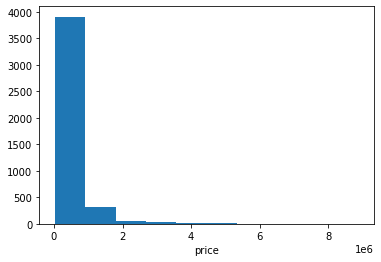

In [32]:
plt.hist(y)
plt.xlabel("price")
plt.show()

Our y values seem to be quite skewed! 
With a linear regression, extreme values tend to have a lot of influence on the slope and intercept of the model. 
If we want our model to fit better to a larger proportion of the data, we need to get rid of these extreme values when fitting the model. Let's try that next.

The 10^6 cutoff here is completely subjective and is up to the data analyst to decide. 
We chose 10^6 simply because as college students, any car that sells for more then $1,000,000 second hand seems outrageous!

In [33]:
non_extreme_cars_with_dummies = cars_with_dummies[cars_with_dummies['selling_price'] <1000000]

# assign model to a variable 
model2 = lm.LinearRegression()

# fit model based on data

#our x, the predictor variables
X = non_extreme_cars_with_dummies.drop(columns=['selling_price'])
# our y, the price of the cars
y = non_extreme_cars_with_dummies['selling_price']
model2.fit(X, y)
predictions = model2.predict(X)
actual = y
print(rmse(actual, predictions))
print(np.mean(actual), np.std(actual))

151699.1009755904
374996.3530005043 226111.1722817133


Much better!

## Residual analysis

Another way to assess the fit of out model is through the residual of the regression: actual - predicted. 
If our model fit the data well, then the residual should be very close to the distribution of random noise. 
Much like most things in the natural world, we ususally assume that random noise follow a normal distribution, this time centered around 0. 
How did our model do? Does the distribution of the residuals look roughly normal? Let's find out:


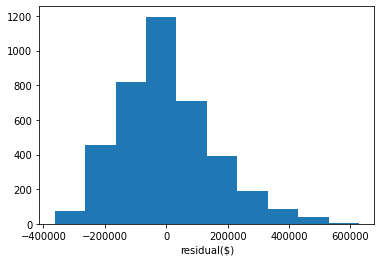

8.404916185233788e-09


In [34]:
residual = actual-predictions
plt.hist(residual)
plt.xlabel("residual($)")
plt.show()
print(np.mean(residual))

Not bad! The histogram is roughly normal and the average of our sample residuals is very close to zero. 
We can see a slight skew towards the right, which may have been caused by the very expensive cars that are still not filtered out from our data. 
But otherwise the distribution of residuals is similar to what we would expect: roughly normal. 

One down side of multivariate regression is that we can't really visually diagnose how well the regression fits the data, since our data will be n-ish-dimensional, depending on how many features there are. 
This is why looking at and analyzing the distribution of the residuals is so important: it gives us some insight on how the model is actually fitting the data.
If we see a residual plot that does not look like a normal distribution at all, then maybe it's time to re-assess our assumptions about our data: 
Does it actually follow a linear model? 
Or does it follow some other model that we need to transform the data first before applying linear regression?
Is the residual plot not normal due to outliers, or due to a wrong assumption about which underlying model the data follows? 

We don't want to use a model that does not describe/represent the data well, which is why residual analysis should always be done after fitting a regression model. 

### Train-Test Split

Before we start training the model, how do we test that our model will be successful on new data sets, and helps us predict and make decisions? For this reason, it's important to keep a subset of the data to the side. 
This is the "test" data, which will be used to evaluate the accuracy of the model once we have finalized it.
The idea behind this is to train the model on the majority of the dataset (the training set), and make adjustments as necessary if we find that the accuracy is not up to par. 
The testing set will then be used as a FINAL barometer for how well the model performs. 

If adjustments are made after evaluating on the test set, then it is now part of the training set, and a new set of data must be found for testing.
Thus, when we make the initial train-test split, it's important to stick to it-- make as many changes and tweaks as you want based on the training data, but once you test, you are either done with the model, or that data is now part of training.

## Performance Statistics

 When running binary classifications, data scientists need to know and understand how well their models perform. Thankfully, there are numerous statistics to help us 
 understand model performance!

We'll use the `cars` dataframe again.

In [35]:
cars

,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...
4335,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4336,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4337,2009,110000,83000,Petrol,Individual,Manual,Second Owner
4338,2016,865000,90000,Diesel,Individual,Manual,First Owner


The column called `transmission` has information on whether or not the car is manual or automatic. Since there are only two options, we can encode this as a binary variable. We'll define this variable to be 1 if the car is manual and 0 if it is automatic. We'll then try to predict whether or not the car is manual using a technique called logistic regression. You don't have to be familiar with this technique right now, just know that it predicts either a 1 or a 0. These predictions will be saved in the `manual_pred` column.

In [37]:
cars['manual'] = cars['transmission'] == 'Manual'
cars['manual_pred'] = lm.LogisticRegression().fit(cars[['year', 'selling_price', 'km_driven']], cars['manual']).predict(cars[['year', 'selling_price', 'km_driven']])

From here we can start discussing our performance statistics! One of the first performance statistics that we will learn are the number of true positives (TP) 
and true negatives (TN). This is simply the number of cases that were classified correctly! We can easily show that below by comparing our predictions with our 
actual values:

In [40]:
cars_positive_df = cars[cars['manual_pred'] == 1]
tp = np.count_nonzero(cars_positive_df['manual_pred'] == cars_positive_df['manual'])

cars_negative_df = cars[cars['manual_pred'] == 0]
tn = np.count_nonzero(cars_negative_df['manual_pred'] == cars_negative_df['manual'])

print(f"The number of True Positives is {tp} and the number of True Negatives is {tn}.")
print(f"Out of the {cars.shape[0]} entries in our dataset, this accounts for {100 * (tn + tp) / (cars.shape[0])}% of our data.")

The number of True Positives is 3855 and the number of True Negatives is 158.
Out of the 4340 entries in our dataset, this accounts for 92.46543778801843% of our data.


From here, we can expand from just these True Positive and True Negative values to False Negatives and False Negatives. The methodology to extracting 
False Positives (FP) and False Negatives (FN) is similar to extracting the TP and TN values.

In [41]:
cars_positive_df = cars[cars['manual_pred'] == 1]
fp = np.count_nonzero(cars_positive_df['manual_pred'] != cars_positive_df['manual'])

cars_negative_df = cars[cars['manual_pred'] == 0]
fn = np.count_nonzero(cars_negative_df['manual_pred'] != cars_negative_df['manual'])

print(f"The number of False Positives is {fp} and the number of False Negatives is {fn}.")
print(f"Out of the {cars.shape[0]} entries in our dataset, this accounts for {100 * (fn + fp) / (cars.shape[0])}% of our data.")

The number of False Positives is 290 and the number of False Negatives is 37.
Out of the 4340 entries in our dataset, this accounts for 7.534562211981567% of our data.


From just these counts, we can extract the false negative _rate_ and the false positive _rate_ for our model which are useful to know. By simply dividing the 
number of false predictions with the total number of predictions, we can extract these rates:

In [42]:
fp_rate = fp / cars.shape[0]
fn_rate = fn / cars.shape[0]

print(f"The false positive rate is {fp_rate * 100}% whereas the false negative rate is {fn_rate * 100}%")

The false positive rate is 6.682027649769585% whereas the false negative rate is 0.8525345622119815%


## Train-Test Split

So far we've been fitting a model onto a dataset such that the model is the "best" linear predictor for the data, meaning that the sum of squared errors between the actual outcome values of each point and the model's predicted values is as small as possible. If we feed in a point in out dataset into the model, we can be confident that the predicted value of that point will be as close to the actual value of the point as possible, under the constraint that the model has to account for every other point in the dataset as well. But what about new observations that don't appear in the dataset? For instance, in the example of predicting a person's earnings based on their education and other variables, we can fit a model to some existing data that we have, but how confident can we be that if we were to predict the earnings of a person which did not appear in our dataset, our prediction would be close?

This is an important question to be able to answer, as typically in data science we construct models so that we might be able to make predictions on new observations that we haven't seen before. While at first it might seem like our model should certainly be able to predict new observations just as well as observations in our dataset, this isn't necessarily the case. Many times our models "overfit" to the data, meaning they learn the dataset a little too well, such that they actually lose their ability to accurately predict previously-unseen examples. For instance, consider a dataset of people and their education and earnings information, but just by pure chance the average earnings of people with high school degrees is slightly lower in our dataset than in the population. In this case our model will fit slightly lower earnings for people with high school degrees than it should. You can't really blame it, it's just doing its best to learn from the data we've given it. Now, when we get more samples from the population, our model will predict slightly lower earnings for people who only completed high school than it probably should. This is overfitting.

Overfitting is a problem because after you train your model, you typically want to have some measure of its accuracy. How would you measure this? Well so far, the only way we would know how to would be to make predictions for each point in our dataset and see on average how close we are to the correct outcome value. But if our model overfits the data, then that means its predictions will be closer to the outcome values in our data than to new observations that it hadn't seen before. The accuracy we calculate from our data will be higher than it really should be! We would be getting an overestimate to how good our model really is.

To protect against overfitting, we perform something called a *train-test split*. What this means is that before we do any data science at all, we set aside a small portion of our dataset for *testing*, and the rest we keep for *training*. Training is what we've been doing this whole time so far to our datasets. After we've trained our model, have found a measure if its accuracy, and are satisfied with the outcome, we then turn to *testing*. Using that small portion of the dataset we set aside, we make one more measure of the model's accuracy, but this time only using these set aside points. Since these points were set aside before we did any further work, we know for certain that our model could not have overfit to them in particular. Therefore, when we compute the accuracy of our model on these test points, we can have a much better idea on how our model will perform on new never-before-seen data, because technically these test points *are* new and have never been seen before!

Of course, in order for this to work at all you must be careful to never use your test points at any point in your modelling, otherwise they no longer replicate unseen points (your model has seen them). In fact, you shouldn't even really use the test set to make decisions when you have to choose which of two models is the better one. Let's see why: suppose you've trained two models and they both do equally-well on the training set. So now you revert to the test set and find that one of them gets slightly higher accuracy there, so you take that one and discard the other. Now, because you've made a modelling decision based on these test points, it is actually possible that you are overfitting these points! It's possible that by pure chance the model you selected happened to be better-calibrated to predict the specific points in the test set (remember the test set is just a small random sample of points from some overall population) and not necessarily any arbitrary unseen point. Of course it could also be possible that the model you chose was genuinely the better model, and the accuracy from the test set simply reflected this, but there's no way to be completely sure without collecting more data! For this reaosn, we typically only use the test set for reporting the final accuracy of a model before either putting the model to use or publishing the model results (whichever was the purpose of creating the model in the first place) and *not* making decisions on how to further develop the model. This would fall under *training*.

Let's look at a demonstration. We'll use the cars dataset once again.

In [ ]:
cars_with_dummies.head()

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2007,60000,70000,0,0,0,1,1,0,1,0,0,0,0
1,2007,135000,50000,0,0,0,1,1,0,1,0,0,0,0
2,2012,600000,100000,1,0,0,0,1,0,1,0,0,0,0
3,2017,250000,46000,0,0,0,1,1,0,1,0,0,0,0
4,2014,450000,141000,1,0,0,0,1,0,1,0,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split

# X, the design matrix of features
X = cars_with_dummies.drop(columns=["selling_price"])
# intercept term
X["const"] = 1

#y, the true values corresponding to X
y = cars_with_dummies[["selling_price"]]

# create the TT split with this method from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=35)

print("Shape of X_test: ", X_test.shape, "    Shape of y_test: ", y_test.shape)
print("Shape of X_train:", X_train.shape, "    Shape of y_train:", y_train.shape)

Shape of X_test:  (868, 14)     Shape of y_test:  (868, 1)
Shape of X_train: (3472, 14)     Shape of y_train: (3472, 1)


In [ ]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
car_train_model = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_train_pred = car_train_model.predict(X_train)

print("RMSE of model on training set: ", rmse(y_train, y_train_pred))

RMSE of model on training set:  418670.47085559653


In [ ]:
y_test_pred = car_train_model.predict(X_test)

print("RMSE of model on test set: ", rmse(y_test, y_test_pred))

RMSE of model on test set:  452014.4414562764


As you can see here, the training RMSE was a good indication of the testing RMSE, but it underpredicted the level of error.
This makes sense intuitively, as the model was trained on the training set and as such will predict it with a higher level of accuracy than unseen data. 
It is possible for test RMSE to be lower than training RMSE, but it is rare. 

In [ ]:
model = lm.LinearRegression(fit_intercept=False).fit(X, y)
y_pred = car_train_model.predict(X)

print("RMSE of model on entire set: ", rmse(y, y_pred))

RMSE of model on entire set:  425548.3304986208


Now, we can see the RMSE on the entirety of the dataset. 
Once again, the training data does a pretty good job at estimating the error for the whole set (it does comprise 80% of it), but will underpredict as explained above. 

In [ ]:
cps_model.coef_

array([[ 3.67976997e+04, -8.41269335e-01,  2.85683308e+05,
        -1.86264515e-08,  5.48927654e+04,  2.55343934e+03,
        -8.19666089e+04,  1.05281843e+05, -9.06183099e+05,
        -1.33715191e+04, -4.48061063e+04,  1.30260555e+05,
        -3.61615720e+04, -7.27724306e+07]])